### Imports:

In [67]:
import numpy as np
import numpy.matlib
import tensorflow as tf
import matplotlib.pyplot as plt
import importlib
from datetime import datetime
import glob

In [68]:
from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, Lambda, RNN
from keras import backend as K
import keras.regularizers
import keras.optimizers
from graphviz import Source
from IPython.display import Image
from IPython.display import SVG
from itertools import count
!pip install pythomata
import pythomata
from pythomata import SimpleDFA

### Función para copiar los pesos de una red a otra:

In [69]:
def copia_pesos(source_model, dest_model):
  for source_layer, dest_layer in zip(source_model.layers, dest_model.layers):
    dest_layer.set_weights(source_layer.get_weights())

### Clases para implementar las células recurrentes de entrenamiento y de test:

In [70]:
class SampleRNNCell(keras.layers.Layer):

  def __init__(self, units, **kwargs):
    self.units = units
    self.state_size = tf.TensorShape([units])
    super(SampleRNNCell, self).__init__(**kwargs)

  def get_config(self):
    config = super().get_config().copy()
    config.update({'units': self.units})
    return config
    
  def build(self, input_shape):
    self.Wxh = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='uniform',
                               name='kernel')
    self.Whh = self.add_weight(shape=(self.units, self.units),
                               initializer='uniform',
                               name='recurrent_kernel')
    self.b = self.add_weight(shape=(self.units,),
                             initializer='uniform',
                             name='bias')
    self.built = True

  def call(self, inputs, states):
    h_prev = states[0]
    x = inputs
    logits = keras.backend.dot(x, self.Wxh) + keras.backend.dot(h_prev, self.Whh) + self.b
    z = tf.math.sigmoid(logits)
    h = tf.cast(tf.random.uniform(z.shape) < z, dtype=tf.float32)
    return [logits, h], [h]

In [71]:
class SampleRNNCellTest(keras.layers.Layer):

  def __init__(self, units, **kwargs):
    self.units = units
    self.state_size = tf.TensorShape([units])
    super(SampleRNNCellTest, self).__init__(**kwargs)
    
  def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units
        })
        return config

  def build(self, input_shape):
    self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='uniform',
                                  name='kernel')
    self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                            initializer='uniform',
                                            name='recurrent_kernel')
    self.bias = self.add_weight(shape=(self.units,),
                                initializer='uniform',
                                name='bias')
    self.built = True

  def call(self, inputs, states):
    prev_output = states[0]
    logits = keras.backend.dot(inputs, self.kernel) + keras.backend.dot(prev_output, self.recurrent_kernel) + self.bias
    z = tf.math.sigmoid(logits)
    s = 0.5 < z
    output = tf.cast(s, dtype=tf.float32)

    return [output, logits], [output]

### Función para crear el modelo de test:

In [72]:
def crea_modelo_test(nunits, l1reg, batch_size, seq_len, input_dim, output_dim):

  model_inputs = keras.Input(batch_shape=(batch_size, seq_len, input_dim))
  cell = SampleRNNCellTest(nunits)
  rnn, logits = RNN(cell, return_sequences=True, stateful=True, unroll=False)(model_inputs)
  y = Dense(output_dim, activation='softmax', kernel_regularizer=keras.regularizers.l1(l1reg))(rnn)
  model = keras.Model(inputs=model_inputs, outputs=[rnn, logits, y])
  return model

### Código para cargar el modelo previamente entrenado y ponerlo a prueba mediante el modelo de test:

In [73]:
model = crea_modelo_test(20, 0, 3, 1, 3, 2)
model_weights = keras.models.load_model('/kaggle/input/pesos-automatas/pesos/tomita1_999_2023031015.h5', custom_objects={'SampleRNNCell': SampleRNNCell})
copia_pesos(model_weights, model)

In [74]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(3, 1, 3)]               0         
                                                                 
 rnn_9 (RNN)                 [(3, 1, 20),              480       
                              (3, 1, 20)]                        
                                                                 
 dense_9 (Dense)             (3, 1, 2)                 42        
                                                                 
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


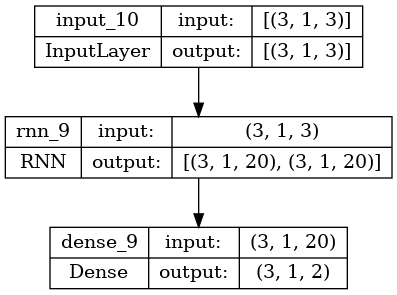

In [75]:
keras.utils.plot_model(model, show_shapes=True)

### Modificación del algoritmo de búsqueda en anchura para descubrir todas las transiciones y los estados finales del autómata implementado por la red:

In [76]:
x = np.array([[1,0,0],[0,1,0],[0,0,1]])[:,None,:]
zero_state = tuple(np.zeros(20).tolist())
model.layers[1].reset_states(states=np.array([zero_state, zero_state, zero_state]))
aux_state = tuple(model(x)[0][0][0].numpy().tolist())
model.layers[1].reset_states(states=np.array([aux_state, aux_state, aux_state]))
initial_state = tuple(model(x)[0][0][0].numpy().tolist())
queue = []
discovered = [initial_state]
connections = {tuple(initial_state): {}}
queue.append(initial_state)
accept = {}

while queue:
    state = queue.pop(0)
    model.layers[1].reset_states(states=np.array([state, state, state]))
    new_states, _, probabilities = model(x)
    i = 0
    for aux in new_states:
        new_state = tuple(aux[0].numpy().tolist())
        if state not in connections:
            connections[state] = {}
        connections[state][i] = new_state
        if new_state not in accept:
            accept[new_state] = True if probabilities[i][0][0] < 0.5 else False
        if new_state not in discovered:
            discovered.append(new_state)
            queue.append(new_state)
        i += 1

### Bloques de código para representar gráficamente el AFD y el AFD minimizado implementado por la red:

In [77]:
d = {}
c = count()
estados = [d.setdefault(i, next(c)) for i in connections.keys()]

finales = np.full(len(estados), False).tolist()
for state, value in accept.items():
    if value:
        finales[list(d.keys()).index(state)] = True

transiciones = {}
for state, transitions in connections.items():
    for symbol, new_state in transitions.items():
        if (d[state], d[new_state]) not in transiciones:
            transiciones[(d[state], d[new_state])] = []
        transiciones[(d[state], d[new_state])].append('$' if symbol == 0 else 'a' if symbol == 1 else 'b')

In [78]:
def write_dot(states, final, transitions, file):
  with open(file, "w") as f:
    f.write("digraph {\n")
    f.write("  rankdir=LR;\n\n")
    f.write("  start [style=invis];\n")

    for s, is_final in zip(states, final):
      if is_final:
        f.write(f'  q{s}[label=<q<sub>{s}</sub>>, shape="doublecircle", color="black"];\n')
      else:
        f.write(f'  q{s}[label=<q<sub>{s}</sub>>, shape="circle", color="black"];\n')

    f.write("\n")
    f.write(f'  start -> q{states[0]}[color="black"];\n')
    for s, symbols in transitions.items():
        label = ",".join(symbols)
        f.write(f'  q{s[0]} -> q{s[1]}[label="{label}", color="black", fontcolor="black"];\n')
    f.write("}\n")

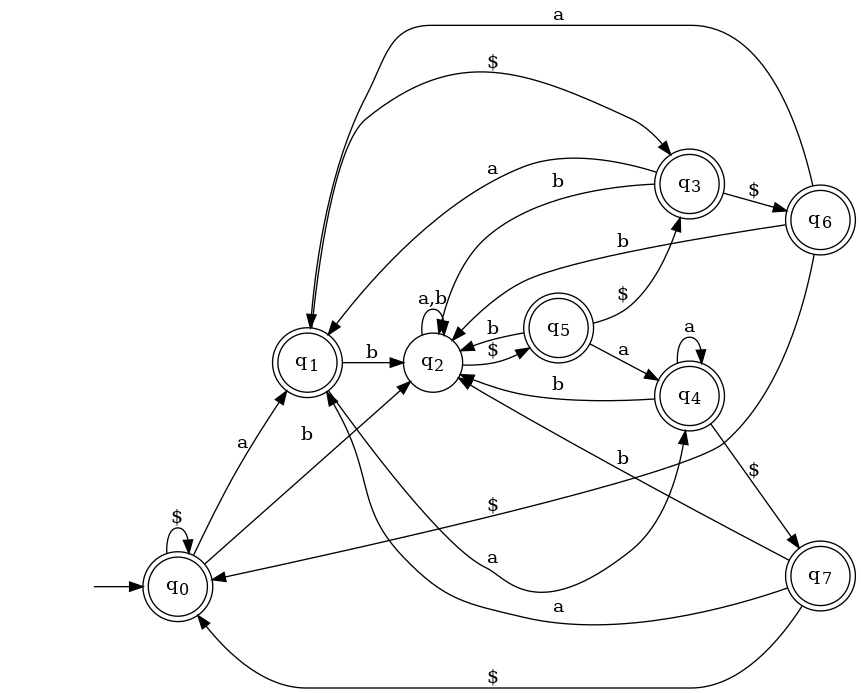

In [79]:
write_dot(estados, finales, transiciones, "kkk.dot")

with open('kkk.dot', 'r') as f:
    dot_source = f.read()

s = Source(dot_source, filename="test.gv", format="png")
s.view()

Image('test.gv.png')

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'test.gv.png'


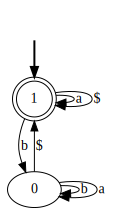

In [80]:
alphabet = {"$", "a", "b"}

states = set(estados)

initial_state = estados[0]

accepting_states = set()
i = 0
for value in finales:
    if value:
        accepting_states.add(i)
    i += 1
    
transition_function = {}
for (current, new), symbols in transiciones.items():
    if current not in transition_function:
        transition_function[current] = {}
    for symbol in symbols:
        transition_function[current][symbol] = new

dfa = SimpleDFA(states, alphabet, initial_state, accepting_states, transition_function)
dfa.minimize().to_graphviz().render("minimized")
SVG('/kaggle/working/minimized.svg')